This notebook gives some examples of the Widely Applicable Bayesian Information Criterion (WBIC) and its use with STAN.


The three cases considered are:
<ol>
<li>Linear Model vs Generalized Linear Model</li>
<li>Linear model feature selection </li>
<li>AR order determination </li>
</ol>

In [1]:
# this section imports stuff 
import pandas as pd
import numpy as np
import pystan
import matplotlib.pyplot as plt
import seaborn as sns
from pystan import StanModel
import arviz as az
from platform import python_version
import matplotlib.pyplot as plt
from orbit.utils.simulation import make_regression

In [2]:
%matplotlib inline

In [3]:
# check the things!
print('pandas: {}'.format(pd.__version__))
print('numpy: {}'.format(np.__version__))
print('pystan: {}'.format(pystan.__version__))
print(python_version())

pandas: 1.3.4
numpy: 1.21.4
pystan: 2.19.1.1
3.7.10


This section gives the WAIC function. For it to work the models must have a log probability of each observation for each sample. 

Note that the penalty term (k) is currently left as an argument to the user. In "Understanding predictive information criteria for Bayesian models” and "Practical Bayesian model evaluation using leave-one-out cross-validation and WAIC" k=2 is assumed. As is discussed here k = log(n) mighte be another choice. Note this is not WBIC which is its own thing. 



In [24]:
#WAIC
def WAIC(log_p, k = 2 ):
    P_WAIC2 = np.nansum(log_p.var(axis=0)) # the effective number of paramters 
    lppd = np.nansum(np.log(np.exp(log_p).mean(axis=0))) # the sum of log pointwise predictive density
    WAIC = -2*lppd +k* P_WAIC2 
    return WAIC, lppd, P_WAIC2


def WBIC(log_p): # note that log P must he sampled at temp log(n)
    return -2*np.nanmean(log_p)



## First example:
This example considers the fitting of linear model with both a normal and a  Generalized normal distribution 

In [16]:
# make data 
n = 10000
x0 = np.ones(n)
x1 = np.random.normal(0, 10, n)
x2 = np.random.normal(0, 0.5, n)

X = np.vstack([x0, x1, x2]).transpose()


coefs = np.array([2.6, 0.2, 0.1])
yhat = np.matmul(X, coefs)
y = np.random.normal(yhat, 1)
print(X.shape)
print(y.shape)
print(coefs)

(10000, 3)
(10000,)
[2.6 0.2 0.1]


Four parts to a STAN process. Data, Model, Fitting, and outputs

In [17]:
# data
data = {
    'n_obs': len(y),
    'n_features': X.shape[1],
    'y': y,
    'X': X,
}

In [18]:
# make model 1 
model_code = """

    data {
      int<lower=0> n_obs;
      int<lower=0> n_features;
      vector[n_obs] y;
      // real y[n_obs];
      matrix[n_obs, n_features] X;
    }
    
    parameters{
      vector[n_features] m;
      real<lower=0,upper=10> sigma;
    }
    
    transformed parameters {
      vector[n_obs] yhat;
      vector[n_obs] log_p;
      real watanabe_beta;
      watanabe_beta = 1.0/log(n_obs); // the sampling temp  
      
      yhat = X * m;
      for (i in 1:n_obs)
        log_p[i] = normal_lpdf(y[i]|yhat[i], sigma);
    }
    
    model {

      for (i in 1:n_obs)
        target += watanabe_beta*log_p[i];
    }
    
"""
sm_simple = StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6ae105309d20e0781eff0ae7263bdd21 NOW.
In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_9986fqad/stanfit4anon_model_6ae105309d20e0781eff0ae7263bdd21_3821962250780644600.cpp:709:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969:
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, di

  typedef typename AssignmentTraits::PacketType PacketType;
                   ^
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/AssignEvaluator.h:739:10: note: in instantiation of template class 'Eigen::internal::generic_dense_assignment_kernel<Eigen::internal::evaluator<Eigen::Matrix<double, -1, -1, 0>>, Eigen::internal::evaluator<Eigen::Product<Eigen::Matrix<double, -1, -1, 0>, Eigen::Transpose<const Eigen::Matrix<double, -1, -1, 0>>, 1>>, Eigen::internal::assign_op<double, double>, 0>' requested here
  Kernel kernel(dstEvaluator, srcEvaluator, func, dst.const_cast_derived());
         ^
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/AssignEvaluator.h:879:5: note: in instantiation of function template specialization 'Eigen::internal::call_dense_assignment_loop<Eigen::Matrix<double, -1, -1, 0>, Eigen::Product<Ei

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_9986fqad/stanfit4anon_model_6ae105309d20e0781eff0ae7263bdd21_3821962250780644600.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_9986fqad/stanfit4anon_model_6ae105309d20e0781eff0ae7263bdd21_3821962250780644600.cpp:719:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan_fit.hpp:15:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/additive_combine.hpp:27:
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:140:20: warning: overlapping comparisons always evaluate to false [-Wtautological-overlap-compare]
        if(_x <= 0 && _x != 0) {
           ~~~~~~~~^~~~~~~~~~
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:393:11: note: in instantiation of member function

  Kernel kernel(dstEvaluator, srcEvaluator, func, dst.const_cast_derived());
         ^
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/AssignEvaluator.h:879:5: note: in instantiation of function template specialization 'Eigen::internal::call_dense_assignment_loop<Eigen::Transpose<Eigen::Block<Eigen::Matrix<double, -1, -1, 0>, -1, -1, false>>, Eigen::Transpose<Eigen::Block<Eigen::Matrix<double, -1, -1, 0>, -1, -1, false>>, Eigen::internal::assign_op<double, double>>' requested here
    call_dense_assignment_loop(dst, src, func);
    ^
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/AssignEvaluator.h:836:46: note: in instantiation of member function 'Eigen::internal::Assignment<Eigen::Transpose<Eigen::Block<Eigen::Matrix<double, -1, -1, 0>, -1, -1, false>>, Eigen::Transpose<Eigen::Block<Eigen::Matrix<double, -1, -1,

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_9986fqad/stanfit4anon_model_6ae105309d20e0781eff0ae7263bdd21_3821962250780644600.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_9986fqad/stanfit4anon_model_6ae105309d20e0781eff0ae7263bdd21_3821962250780644600.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_9986fqad/stanfit4anon_model_6ae105309d20e0781eff0ae7263bdd21_3821962250780644600.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_9986fqad/stanfit4anon_model_6ae105309d20e0781eff0ae7263bdd21_3821962250780644600.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_9986fqad/stanfit4anon_model_6ae105309d20e0781eff0ae7263bdd21_3821962250780644600.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_9986fqad/stanfit4anon_model_6ae105309d20e0781eff0ae7263bdd21_3821962250780644600.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_9986fqad/stanfit4anon_model_6ae105309d20e0781eff0ae7263bdd21_3821962250780644600.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

155 warnings generated.


In [19]:
# make model 2 
model_code = """
    functions{
    real gen_norm_lpdf(real x, real alpha, real beta, real mu){
        return(log(beta) - log(2*alpha)- lgamma(1/beta) - pow(fabs(x-mu)/alpha, beta) );        
        }
    }


    data {
      int<lower=0> n_obs;
      int<lower=0> n_features;
      vector[n_obs] y;
      // real y[n_obs];
      matrix[n_obs, n_features] X;
    }
    

    
    parameters{
      vector[n_features] m;
      real<lower=0> alpha;
      real<lower=0,upper=5> beta;
    }
    
    transformed parameters {
      vector[n_obs] yhat;
      vector[n_obs] log_p;
      real watanabe_beta;
      watanabe_beta = 1.0/log(n_obs); // the sampling temp  
      yhat = X * m;
      for (i in 1:n_obs)
          log_p[i] = log(beta) - log(2*alpha)- lgamma(1/beta) - pow(fabs(y[i]-yhat[i])/alpha, beta);
    }
    
    model {
      //vector[n_obs] yhat;
      //yhat = X * m;
      alpha ~ uniform(0, 10);
      beta ~ uniform(0, 5);
      
      for (i in 1:n_obs)
          target += watanabe_beta*log_p[i];
    }
    
"""
sm_complex = StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d8f24b83a2d491827d4e5301a729307 NOW.
In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_a0ahzqb0/stanfit4anon_model_1d8f24b83a2d491827d4e5301a729307_6984430816933544942.cpp:709:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969:
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, di

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_a0ahzqb0/stanfit4anon_model_1d8f24b83a2d491827d4e5301a729307_6984430816933544942.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_a0ahzqb0/stanfit4anon_model_1d8f24b83a2d491827d4e5301a729307_6984430816933544942.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_a0ahzqb0/stanfit4anon_model_1d8f24b83a2d491827d4e5301a729307_6984430816933544942.cpp:719:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan_fit.hpp:15:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/additive_combine.hpp:27:
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:140:20: warning: overlapping comparisons always evaluate to false [-Wtautological-overlap-compare]
        if(_x <= 0 && _x != 0) {
           ~~~~~~~~^~~~~~~~~~
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:393:11: note: in instantiation of member function

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_a0ahzqb0/stanfit4anon_model_1d8f24b83a2d491827d4e5301a729307_6984430816933544942.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_a0ahzqb0/stanfit4anon_model_1d8f24b83a2d491827d4e5301a729307_6984430816933544942.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_a0ahzqb0/stanfit4anon_model_1d8f24b83a2d491827d4e5301a729307_6984430816933544942.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_a0ahzqb0/stanfit4anon_model_1d8f24b83a2d491827d4e5301a729307_6984430816933544942.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

    call_dense_assignment_loop(dst, src, func);
    ^
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/AssignEvaluator.h:836:46: note: in instantiation of member function 'Eigen::internal::Assignment<Eigen::Block<Eigen::Matrix<double, -1, -1, 0>, -1, 1, true>, Eigen::Block<Eigen::Matrix<double, -1, -1, 0>, -1, 1, true>, Eigen::internal::swap_assign_op<double>, Eigen::internal::Dense2Dense, void>::run' requested here
  Assignment<ActualDstTypeCleaned,Src,Func>::run(actualDst, src, func);
                                             ^
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/AssignEvaluator.h:804:3: note: (skipping 1 context in backtrace; use -ftemplate-backtrace-limit=0 to see all)
  call_assignment_no_alias(dst, src, func);
  ^
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pyst

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_a0ahzqb0/stanfit4anon_model_1d8f24b83a2d491827d4e5301a729307_6984430816933544942.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_a0ahzqb0/stanfit4anon_model_1d8f24b83a2d491827d4e5301a729307_6984430816933544942.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_a0ahzqb0/stanfit4anon_model_1d8f24b83a2d491827d4e5301a729307_6984430816933544942.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_a0ahzqb0/stanfit4anon_model_1d8f24b83a2d491827d4e5301a729307_6984430816933544942.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_a0ahzqb0/stanfit4anon_model_1d8f24b83a2d491827d4e5301a729307_6984430816933544942.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

155 warnings generated.


In [20]:
# fit the models 
fit_simple = sm_simple.sampling(data=data, iter=10000, chains=4, verbose =True)
fit_complex = sm_complex.sampling(data=data, iter=10000, chains=4, verbose =True)


Gradient evaluation took 0.001209 seconds
1000 transitions using 10 leapfrog steps per transition would take 12.09 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)

Gradient evaluation took 0.001238 seconds
1000 transitions using 10 leapfrog steps per transition would take 12.38 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)

Gradient evaluation took 0.00141 seconds
1000 transitions using 10 leapfrog steps per transition would take 14.1 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.007361 seconds
1000 transitions using 10 leapfrog steps per transition would take 73.61 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 200

To run all diagnostics call pystan.check_hmc_diagnostics(fit)



Gradient evaluation took 0.004683 seconds
1000 transitions using 10 leapfrog steps per transition would take 46.83 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)

Gradient evaluation took 0.006884 seconds
1000 transitions using 10 leapfrog steps per transition would take 68.84 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.005759 seconds
1000 transitions using 10 leapfrog steps per transition would take 57.59 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration:    1 / 10000 [  0%]  (Warmup)

Gradient evaluation took 0.00771 seconds
1000 transitions using 10 leapfrog steps per transition would take 77.1 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 200

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [21]:
# extract the posteriors
posteriors_simple = fit_simple.extract(permuted=True)  # return a dictionary of arrays
print(posteriors_simple.keys())

posteriors_complex = fit_complex.extract(permuted=True)  # return a dictionary of arrays
print(posteriors_complex.keys())

odict_keys(['m', 'sigma', 'yhat', 'log_p', 'watanabe_beta', 'lp__'])
odict_keys(['m', 'alpha', 'beta', 'yhat', 'log_p', 'watanabe_beta', 'lp__'])


In [25]:
WBIC_s = WBIC(log_p = posteriors_simple['log_p'])
WBIC_c = WBIC(log_p = posteriors_complex['log_p'])

print(WBIC_s)
print(WBIC_c)

2.8236426211409267
2.824571627208082


## Example 2
Feature selection for linear models with WBIC.

In [26]:
# make data 
n = 1000
x0 = np.ones(n)
x1 = np.random.normal(0, 1, n)
x2 = np.random.normal(0, 1, n)
x3 = np.random.normal(0, 1, n)
x4 = np.random.normal(0, 1, n)
x5 = np.random.normal(0, 1, n)
x6 = np.random.normal(0, 1, n)
x7 = np.random.normal(0, 1, n)
x8 = np.random.normal(0, 1, n)
x9 = np.random.normal(0, 1, n)

X9 = np.vstack([x0, x1, x2, x3, x4, x5, x6, x7, x8, x9]).transpose()
X = np.vstack([x0, x1, x2]).transpose()
coefs = np.array([2.6, 0.2, 0.1])
yhat = np.matmul(X, coefs)
y = np.random.normal(yhat, 1)
print(X.shape)
print(y.shape)
print(coefs)

(1000, 3)
(1000,)
[2.6 0.2 0.1]


In [27]:
data = {
    'n_obs': len(y),
    'n_features': X.shape[1],
    'y': y,
    'X': X,
}

In [29]:

model_code = """

    data {
      int<lower=0> n_obs;
      int<lower=0> n_features;
      vector[n_obs] y;
      // real y[n_obs];
      matrix[n_obs, n_features] X;
    }
    
    parameters{
      vector[n_features] m;
      real<lower=0> sigma;
    }
    
    transformed parameters {
      vector[n_obs] yhat;
      vector[n_obs] log_p;
      real watanabe_beta;
      watanabe_beta = 1.0/log(n_obs); // the sampling temp  
      
      yhat = X * m;
      for (i in 1:n_obs)
        log_p[i] = normal_lpdf(y[i]|yhat[i], sigma);
    }
    
    model {

      for (i in 1:n_obs)
        target += watanabe_beta*log_p[i];
    }
    
"""
sm_temp = StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fe3ecba4592c3e5dbe590abdc55b0ed2 NOW.
In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_ffga74h3/stanfit4anon_model_fe3ecba4592c3e5dbe590abdc55b0ed2_1370405577722370105.cpp:709:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969:
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, di

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_ffga74h3/stanfit4anon_model_fe3ecba4592c3e5dbe590abdc55b0ed2_1370405577722370105.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_ffga74h3/stanfit4anon_model_fe3ecba4592c3e5dbe590abdc55b0ed2_1370405577722370105.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_ffga74h3/stanfit4anon_model_fe3ecba4592c3e5dbe590abdc55b0ed2_1370405577722370105.cpp:719:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan_fit.hpp:15:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/additive_combine.hpp:27:
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:140:20: warning: overlapping comparisons always evaluate to false [-Wtautological-overlap-compare]
        if(_x <= 0 && _x != 0) {
           ~~~~~~~~^~~~~~~~~~
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:393:11: note: in instantiation of member function

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_ffga74h3/stanfit4anon_model_fe3ecba4592c3e5dbe590abdc55b0ed2_1370405577722370105.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_ffga74h3/stanfit4anon_model_fe3ecba4592c3e5dbe590abdc55b0ed2_1370405577722370105.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_ffga74h3/stanfit4anon_model_fe3ecba4592c3e5dbe590abdc55b0ed2_1370405577722370105.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_ffga74h3/stanfit4anon_model_fe3ecba4592c3e5dbe590abdc55b0ed2_1370405577722370105.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_ffga74h3/stanfit4anon_model_fe3ecba4592c3e5dbe590abdc55b0ed2_1370405577722370105.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

    call_dense_assignment_loop(dst, src, func);
    ^
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/AssignEvaluator.h:836:46: note: in instantiation of member function 'Eigen::internal::Assignment<Eigen::Block<Eigen::Block<Eigen::Matrix<double, -1, -1, 0>, 1, -1, false>, 1, -1, false>, Eigen::Block<Eigen::Block<Eigen::Matrix<double, -1, -1, 0>, 1, -1, false>, 1, -1, false>, Eigen::internal::swap_assign_op<double>, Eigen::internal::Dense2Dense, void>::run' requested here
  Assignment<ActualDstTypeCleaned,Src,Func>::run(actualDst, src, func);
                                             ^
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/AssignEvaluator.h:804:3: note: (skipping 3 contexts in backtrace; use -ftemplate-backtrace-limit=0 to see all)
  call_assignment_no_alias(dst, src, func);
  ^
/Users/gavin.steininger

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_ffga74h3/stanfit4anon_model_fe3ecba4592c3e5dbe590abdc55b0ed2_1370405577722370105.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_ffga74h3/stanfit4anon_model_fe3ecba4592c3e5dbe590abdc55b0ed2_1370405577722370105.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_ffga74h3/stanfit4anon_model_fe3ecba4592c3e5dbe590abdc55b0ed2_1370405577722370105.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

155 warnings generated.


In [31]:
# this cell loops through models with different number of features
WBIC_list = np.zeros((10))


for i in range(1, 10):
    X = X9.copy()
    X = X[:,:i]
    print(X.shape[1])
    data = {
        'n_obs': len(y),
        'n_features': X.shape[1],
        'y': y,
        'X': X,
    }
    
    fit_temp = sm_temp.sampling(data=data, iter=2000, chains=4, verbose =False)
    posteriors_temp = fit_temp.extract(permuted=True)
    WBIC_v = WBIC(log_p = posteriors_temp['log_p'])
    WBIC_list[i-1] = WBIC_v

    
    print("-------------------------------------------------------------------------------")
    print(i)
    print(WBIC_v)
    print("-------------------------------------------------------------------------------")    
    
    
    

1

Gradient evaluation took 0.0004 seconds
1000 transitions using 10 leapfrog steps per transition would take 4 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000477 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.77 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000399 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.99 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 0.000294 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.94 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 24)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1600 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
1
2.9448342308260242
-------------------------------------------------------------------------------
2

Gradient evaluation took 0.000353 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.53 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000299 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.99 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 0.000316 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.16 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000598 seconds
1000 transitions using 10 leapfrog steps per transition would take 5.98 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
I

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 24)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
2
2.8979205966989565
-------------------------------------------------------------------------------
3

Gradient evaluation took 0.000712 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.12 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000682 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.82 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00038 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.8 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)

Iteration:    1 / 2000 [  0%]  (Warmup)
Gradient evaluation took 0.000376 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.76 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Ite

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 24)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 24)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the 

Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1400 / 2000 [

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 0.65687 seconds (Warm-up)
               1.59936 seconds (Sampling)
               2.25623 seconds (Total)

-------------------------------------------------------------------------------
3
2.893583095096724
-------------------------------------------------------------------------------
4


Gradient evaluation took 0.000333 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.33 seconds.
Adjust your expectations accordingly!


Gradient evaluation took 0.000338 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.38 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000403 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.03 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 0.000328 seconds
1000 transitions using 10 leapfrog st

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 24)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 24)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1400 / 2000 [

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
4
2.8983807470034892
-------------------------------------------------------------------------------
5

Gradient evaluation took 0.001138 seconds
1000 transitions using 10 leapfrog steps per transition would take 11.38 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 0.000353 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.53 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000327 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.27 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 0.000342 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.42 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
5
2.9055358209523776
-------------------------------------------------------------------------------
6

Gradient evaluation took 0.000341 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.41 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 0.000815 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.15 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000635 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.35 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000376 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.76 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
I

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 24)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
6
2.912226433961337
-------------------------------------------------------------------------------
7

Gradient evaluation took 0.000323 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.23 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000368 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.68 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 0.001619 seconds
1000 transitions using 10 leapfrog steps per transition would take 16.19 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000324 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.24 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
I

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 24)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
7
2.9201387595045127
-------------------------------------------------------------------------------
8

Gradient evaluation took 0.000626 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.26 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000743 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.43 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000615 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.15 seconds.
Adjust your expectations accordingly!



Iteration:    1 / 2000 [  0%]  (Warmup)
Gradient evaluation took 0.000431 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.31 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
I

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 24)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
8
2.9256662893966427
-------------------------------------------------------------------------------
9

Gradient evaluation took 0.000275 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.75 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000375 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.75 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000366 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.66 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000357 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.57 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
I

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 24)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 24)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
9
2.93248116965829
-------------------------------------------------------------------------------


[2.94483423 2.8979206  2.8935831  2.89838075 2.90553582 2.91222643
 2.92013876 2.92566629 2.93248117 0.        ]


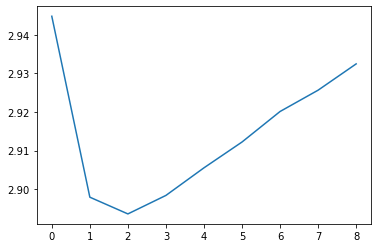

In [35]:
print(WBIC_list)

plt.plot(WBIC_list[0:9])

The min WAIC should be for the 3rd itteration

## Example 3
AR order selections

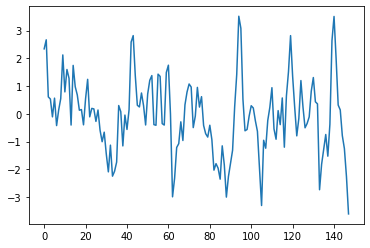

In [36]:
# make the data
n = 1000
eta = np.random.normal(0, 1, n)
rho = [0.85, -0.25]
y = eta.copy()
for i in range(2, n):
    y[i] = rho[0]*y[i-1] + rho[1]*y[i-2] + eta[i]

#plt.plot(y)
plt.plot(y[2:150])

In [37]:
data = {
    'N': len(y),
    'K': 3,
    'y': y,
}

In [39]:

model_code = """
    data {
      int<lower=0> K;
      int<lower=0> N;
      real y[N];
    }
    parameters {
      real<lower=-1,upper=1> rho[K];
      real sigma;
    }
    
    
    transformed parameters {
        vector[N] yhat;
        vector[N] log_p;
        real watanabe_beta;
        watanabe_beta = 1.0/log(N); // the sampling temp  
      
        for (i in (K+1):N) {
            yhat[i] = 0;
            for (k in 1:K)
              yhat[i] += rho[k] * y[i-k];
            log_p[i] = normal_lpdf(y[i]|yhat[i], sigma);
            }
    }
    
    
    model {
      
      for (i in (K+1):N) 
        target += watanabe_beta*log_p[i];
      
    }"""
AR_K = StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8d13ae140c2fc8f2ef2c5e7dfec0b4b6 NOW.
In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_yflza09n/stanfit4anon_model_8d13ae140c2fc8f2ef2c5e7dfec0b4b6_2204933600882881631.cpp:709:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969:
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, di

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_yflza09n/stanfit4anon_model_8d13ae140c2fc8f2ef2c5e7dfec0b4b6_2204933600882881631.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/AssignEvaluator.h:836:46: note: in instantiation of member function 'Eigen::internal::Assignment<Eigen::Matrix<double, 1, -1, 1>, Eigen::Matrix<double, 1, -1, 1>, Eigen::internal::assign_op<double, double>, Eigen::internal::Dense2Dense, void>::run' requested here
  Assignment<ActualDstTypeCleaned,Src,Func>::run(actualDst, src, func);
                                             ^
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/PlainObjectBase.h:728:17: note: in instantiation of function template specialization 'Eigen::internal::call_assignment_no_alias<Eigen::Matrix<double, 1, -1, 1>, Eigen::Matrix<double, 1, -1, 1>, Eigen::internal::assign_op<double, double>>' requested here
      internal::call_assignment_no_alias(this->derived(), other.derived(), internal::assign_o

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_yflza09n/stanfit4anon_model_8d13ae140c2fc8f2ef2c5e7dfec0b4b6_2204933600882881631.cpp:719:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan_fit.hpp:15:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/additive_combine.hpp:27:
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:140:20: warning: overlapping comparisons always evaluate to false [-Wtautological-overlap-compare]
        if(_x <= 0 && _x != 0) {
           ~~~~~~~~^~~~~~~~~~
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:393:11: note: in instantiation of member function

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_yflza09n/stanfit4anon_model_8d13ae140c2fc8f2ef2c5e7dfec0b4b6_2204933600882881631.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_yflza09n/stanfit4anon_model_8d13ae140c2fc8f2ef2c5e7dfec0b4b6_2204933600882881631.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_yflza09n/stanfit4anon_model_8d13ae140c2fc8f2ef2c5e7dfec0b4b6_2204933600882881631.cpp:719:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan_fit.hpp:15:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/additive_combine.hpp:27:
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:140:20: warning: overlapping comparisons always evaluate to false [-Wtautological-overlap-compare]
        if(_x <= 0 && _x != 0) {
           ~~~~~~~~^~~~~~~~~~
/Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/additive_combine.hpp:82:16: note: in instantiation of member function 'bo

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_yflza09n/stanfit4anon_model_8d13ae140c2fc8f2ef2c5e7dfec0b4b6_2204933600882881631.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_yflza09n/stanfit4anon_model_8d13ae140c2fc8f2ef2c5e7dfec0b4b6_2204933600882881631.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_yflza09n/stanfit4anon_model_8d13ae140c2fc8f2ef2c5e7dfec0b4b6_2204933600882881631.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_yflza09n/stanfit4anon_model_8d13ae140c2fc8f2ef2c5e7dfec0b4b6_2204933600882881631.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

In file included from /var/folders/2r/w1lk3nxj09s73plknkyzzj5m0000gn/T/pystan_yflza09n/stanfit4anon_model_8d13ae140c2fc8f2ef2c5e7dfec0b4b6_2204933600882881631.cpp:718:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/gavin.steininger/Desktop/prob_prog/p37-env/lib/pytho

152 warnings generated.


In [40]:
WBIC_list = np.zeros((10))

for k in range(1, 11):
    data = {
    'N': len(y),
    'K': k,
    'y': y,
    }
    fit_AR_K = AR_K.sampling(data=data, iter=2000, chains=4, verbose =False)
    posteriors_AR_K = fit_AR_K.extract(permuted=True) 
    WBIC_v = WBIC(log_p = posteriors_AR_K['log_p'])
    WBIC_list[k-1] = WBIC_v

    
    print("-------------------------------------------------------------------------------")
    print(k)
    print(WBIC_v)
    print("-------------------------------------------------------------------------------")    
    


Gradient evaluation took 0.000389 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.89 seconds.
Adjust your expectations accordingly!
Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -0.19403, but must be > 0!  (in 'unknown file name' at line 23)




Gradient evaluation took 0.000486 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.86 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000499 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.99 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000469 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.69 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%] 

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -14.4469, but must be > 0!  (in 'unknown file name' at line 23)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -14.6628, but must be > 0!  (in 'unknown file name' at line 23)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected b

Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -0.163283, but must be > 0!  (in 'unknown file name' at line 23)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -0.464655, but must be > 0!  (in 'unknown file name' at line 23)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected

Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 0.555837 seconds (Warm-up)
               0.450172 seconds (Sampling)
               1.00601 seconds (Total)

Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 0.572056 seconds (Warm-up)
               0.543045 seconds (Sampling)
               1.1151 seconds (Total)

Iteration: 2000 / 2000 [100%]  (Sam

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
1
2.9640663937235647
-------------------------------------------------------------------------------

Gradient evaluation took 0.00172 seconds
1000 transitions using 10 leapfrog steps per transition would take 17.2 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000671 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.71 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 0.000738 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.38 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 0.001404 seconds
1000 transitions using 10 leapfrog steps per transition would take 14.04 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -10.13, but must be > 0!  (in 'unknown file name' at line 23)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -15.7463, but must be > 0!  (in 'unknown file name' at line 23)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected bec

Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -0.789652, but must be > 0!  (in 'unknown file name' at line 23)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -1.67178, but must be > 0!  (in 'unknown file name' at line 23)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 1.19754 seconds (Warm-up)
               0.897647 seconds (Sampling)
               2.09518 seconds (Total)

Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampl

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
2
2.8618624501123215
-------------------------------------------------------------------------------

Gradient evaluation took 0.001071 seconds
1000 transitions using 10 leapfrog steps per transition would take 10.71 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001851 seconds
1000 transitions using 10 leapfrog steps per transition would take 18.51 seconds.
Adjust your expectations accordingly!


Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -0.945587, but must be > 0!  (in 'unknown file name' at line 23)

Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -0.410902, but must be > 0!  (in 'unknown file name' at line 23)

Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: no

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -2.05842, but must be > 0!  (in 'unknown file name' at line 23)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -1.25212, but must be > 0!  (in 'unknown file name' at line 23)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected b

Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
3
2.868998406457543
-------------------------------------------------------------------------------
Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -0.420682, but must be > 0!  (in 'unknown file name' at line 23)

Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -0.722841, but must be > 0!  (in 'unknown file name' at line 23)


Gradient evaluation took 0.000697 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.97 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001852 seconds
1000 transitions using 10 leapfrog steps per transition would take 18.52 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00079 seconds
1000 transitions using 10 leapfrog steps per transition wou

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -718.206, but must be > 0!  (in 'unknown file name' at line 23)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -11.9956, but must be > 0!  (in 'unknown file name' at line 23)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -0.360843, but must be > 0!  (in 'unknown file name' at line 23)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 2.12995 seconds (Warm-up)
               2.03983 seconds (Sampling)
               4.16978 seconds (Total)

Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 2.19444 seconds (Warm-up)
               2.15384 seconds (Sampling)
               4.34828 seconds (Tota

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
4
2.877118773056971
-------------------------------------------------------------------------------
Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -1.92184, but must be > 0!  (in 'unknown file name' at line 23)

Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -0.893937, but must be > 0!  (in 'unknown file name' at line 23)


Gradient evaluation took 0.001041 seconds
1000 transitions using 10 leapfrog steps per transition would take 10.41 seconds.
Adjust your expectations accordingly!


Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -0.195312, but must be > 0!  (in 'unknown file name' at line 23)


Rejecting initial value:
Gradient evaluation took 0.00177 seconds
  Er

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -17.2534, but must be > 0!  (in 'unknown file name' at line 23)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -17.8018, but must be > 0!  (in 'unknown file name' at line 23)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected b

Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
5
2.8828568998396733
-------------------------------------------------------------------------------

Gradient evaluation took 0.000924 seconds
1000 transitions using 10 leapfrog steps per transition would take 9.24 seconds.
Adjust your expectations accordingly!


Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -0.321279, but must be > 0!  (in 'unknown file name' at line 23)


Gradient evaluation took 0.00259 seconds
1000 transitions using 10 leapfrog steps per transition would take 25.9 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000851 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.51 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Rejecting initial value:
  Error evaluating the log probability at the initial value.
Excepti

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -0.079182, but must be > 0!  (in 'unknown file name' at line 23)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -0.501425, but must be > 0!  (in 'unknown file name' at line 23)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected

Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
6
2.887177318200741
-------------------------------------------------------------------------------
Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -0.148491, but must be > 0!  (in 'unknown file name' at line 23)


Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -0.215902, but must be > 0!  (in 'unknown file name' at line 23)

Gradient evaluation took 0.002185 seconds
1000 transitions using 10 leapfrog steps per transition would take 21.85 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001275 seconds
1000 transitions using 10 leapfrog steps per transition would take 12.75 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00108 seconds
1000 transitions using 10 leapfrog steps per transition wo

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -1711.06, but must be > 0!  (in 'unknown file name' at line 23)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -51.1938, but must be > 0!  (in 'unknown file name' at line 23)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected b

Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
7
2.8947303210711377
-------------------------------------------------------------------------------
Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -1.73246, but must be > 0!  (in 'unknown file name' at line 23)

Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -0.202377, but must be > 0!  (in 'unknown file name' at line 23)

Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -0.921269, but must be > 0!  (in 'unknown file name' at line 23)

Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -0.0336757, but must be > 0!  (in 'unknown file name' at line 23)


Gradient evaluation took 0.001246 seco

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -0.392575, but must be > 0!  (in 'unknown file name' at line 23)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
8
2.8994562487348094
-------------------------------------------------------------------------------

Gradient evaluation took 0.001253 seconds
1000 transitions using 10 leapfrog steps per transition would take 12.53 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001872 seconds
1000 transitions using 10 leapfrog steps per transition would take 18.72 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001331 seconds
1000 transitions using 10 leapfrog steps per transition would take 13.31 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001212 seconds
1000 transitions using 10 leapfrog steps per transition would take 12.12 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -0.108871, but must be > 0!  (in 'unknown file name' at line 23)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
9
2.907645184052106
-------------------------------------------------------------------------------
Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -0.994241, but must be > 0!  (in 'unknown file name' at line 23)

Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -0.810392, but must be > 0!  (in 'unknown file name' at line 23)

Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -1.87717, but must be > 0!  (in 'unknown file name' at line 23)

Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is -1.10065, but must be > 0!  (in 'unknown file name' at line 23)

Rejecting initial value:
  Error evaluatin

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -2.25817, but must be > 0!  (in 'unknown file name' at line 23)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-------------------------------------------------------------------------------
10
2.913207610117246
-------------------------------------------------------------------------------


[2.96406639 2.86186245 2.86899841 2.87711877 2.8828569  2.88717732
 2.89473032 2.89945625 2.90764518 2.91320761]


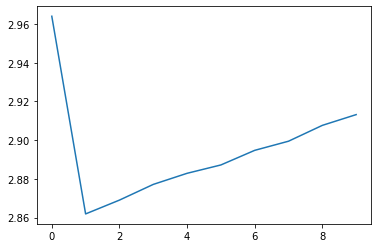

In [42]:
print(WBIC_list)

plt.plot(WBIC_list)

The above should show that the 2nd iteration is best 

In [52]:
pwd()

'/Users/gavin.steininger/Desktop/prob_prog/ts-benchmark/examples/Modules'